In [21]:
import numpy    
import scipy
import pymeshlab
import radarsimpy
print('`RadarSimPy` used in this example is version: ' +
      str(radarsimpy.__version__))


`RadarSimPy` used in this example is version: 11.3.0


# FMCW Radar

[![Documentations](https://img.shields.io/github/v/tag/radarsimx/radarsimpy?label=Documentation&logo=read-the-docs)](https://radarsimx.github.io/radarsimpy/)
[![Download](https://img.shields.io/github/v/tag/radarsimx/radarsimpy?label=Download&logo=python)](https://radarsimx.com/product/radarsimpy/)

## Introduction

An FMCW (Frequency-Modulated Continuous Wave) radar is a type of radar system that uses frequency modulation to continuously transmit a signal with varying frequency. FMCW radar systems are commonly used in various applications, including automotive radar, weather monitoring, navigation, and industrial sensing. They offer several advantages over other radar types, such as pulsed radar.

Here's how FMCW radar works:

1. **Frequency Modulation**: In an FMCW radar, the radar transmitter emits a continuous waveform that changes frequency over time. This waveform is typically a sinusoidal signal. The frequency change occurs in a linear or ramp-like manner, hence the name "Frequency-Modulated Continuous Wave."

2. **Transmit and Receive Phases**: The radar emits the frequency-modulated signal, which travels towards the target. When the signal encounters an object, a portion of it gets reflected back towards the radar receiver.

3. **Mixing and Beat Frequency**: The reflected signal is mixed with the original transmitted signal in the radar receiver. Because the received signal has traveled a certain distance to the target and back, it experiences a frequency shift due to the Doppler effect and the frequency modulation of the transmitted signal. This frequency shift creates a beat frequency that is proportional to the distance and relative velocity of the target.

4. **Signal Processing**: By analyzing the beat frequency, the radar system can determine both the range (distance) and velocity of the target. The range is determined by the phase shift of the beat frequency, and the velocity is derived from the rate of change of the beat frequency over time.

Advantages of FMCW radar include:

1. **Continuous Operation**: FMCW radars operate continuously without interruptions, making them well-suited for tracking moving targets and providing real-time data.

2. **Range and Velocity Information**: FMCW radar can simultaneously provide information about the range and velocity of targets, making it useful for applications such as automotive collision avoidance and speed measurement.

3. **High Range Resolution**: FMCW radar systems can achieve high range resolution due to the continuous waveform and the use of frequency modulation.

4. **Simplicity and Cost-Effectiveness**: FMCW radar systems can be simpler and more cost-effective to implement compared to some other radar types, like pulsed radar.

5. **Adaptability to Multiple Targets**: FMCW radars can handle multiple targets within their field of view due to their continuous operation and the ability to separate different targets based on their individual beat frequencies.

Despite their advantages, FMCW radars also have limitations, such as reduced performance in certain cluttered environments and susceptibility to interference from other radar systems using similar frequencies. However, advancements in signal processing and technology have helped mitigate many of these challenges.

This illustration showcases a simulation of an FMCW radar using the [`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/) framework. It additionally provides a demonstration of fundamental range and Doppler processing techniques for extracting target range and velocity information.

## Create Radar Model

Firstly, import the required modules from `radarsimpy`. `numpy` will also be needed in this example.


In [22]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver


### Transmitter

Setup the basic transmitter parameters through [Transmitter](https://radarsimx.github.io/radarsimpy/radar.html#radarsimpy-transmitter) module.

#### Define Antenna patterns

In this context, we are defining the radiation patterns for both the transmitter and receiver antennas. Please note that idealized patterns are employed for this purpose, but users have the flexibility to incorporate more realistic antenna patterns into the simulation as needed.


In [23]:
az_angle = np.arange(-80, 81, 1)
az_pattern = 20 * np.log10(np.cos(az_angle / 180 * np.pi)**4) + 6

el_angle = np.arange(-80, 81, 1)
el_pattern = 20 * np.log10((np.cos(el_angle / 180 * np.pi))**20) + 6


In [24]:
# H-Plane is Horizontal
# E-Plane is Verticle  

import pandas as pd

# Define the file paths for your CSV files
e_plane_file = "data/E-Plane.csv"
h_plane_file = "data/H-Plane.csv"

# Use pandas to read the CSV data into dataframes
e_plane_df = pd.read_csv(e_plane_file)
h_plane_df = pd.read_csv(h_plane_file)

# You can now work with the dataframes, which are more versatile than NumPy arrays
# For example, you can easily access columns by their headers
el_angle = e_plane_df['Angle']
el_pattern = e_plane_df['Realized Gain']
# e_plane_df['Smooth Realized Gain'] = e_plane_df['Realized Gain'].rolling(window=5).mean()

az_angle = h_plane_df['Angle']
az_pattern = h_plane_df['Realized Gain']

# # can print the first 5 rows of each dataframe
# print("E-Plane Data:")
# print(e_plane_df.head())

# print("\nH-Plane Data:")
# print(h_plane_df.head())


_Plot the antenna patterns_


In [25]:
import plotly.graph_objs as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=el_angle,
    y=el_pattern,
    name='Elevation',
))

fig.add_trace(go.Scatter(
    x=az_angle,
    y=az_pattern,
    name='Azimuth',
))

fig.update_layout(
    title='Antenna Pattern',
    yaxis=dict(title='Amplitude (dB)', range=[-30, 30]),
    xaxis=dict(title='Angle (deg)'),
)

fig.show()

#### Define a Transmitter Channel

Here, the location and the radiation patterns of the transmitter channel are defined. All the other properties, such as `polarization` and `modulation`, etc, are using default values as listed in the [documentation](https://radarsimx.github.io/radarsimpy/radar.html#radarsimpy-transmitter).


In [26]:
tx_channel_1 = dict(
    location=(0, 0, 0),
    azimuth_angle=az_angle,
    azimuth_pattern=az_pattern,
    elevation_angle=el_angle,
    elevation_pattern=el_pattern,
)
tx_channel_2 = dict(
    location=(-0.018654, 0, 0),
    azimuth_angle=az_angle,
    azimuth_pattern=az_pattern,
    elevation_angle=el_angle,
    elevation_pattern=el_pattern,
)

#### Define a Radar Transmitter

As shown in the diagram below, `f` and `t` are used to define the waveform modulation. For a linear frequency-modulated continuous waveform (FMCW), it can be specified as `f = [fstart, fend]` and `t = [tstart, tend]`. If `t` is a single number `t = t0`, which is equivalent to `t = [0, t0]`. The bandwidth of the FMCW is `abs(fstart - fend)`. `prp` is the pulse repetition period, and `prp >= (tend - tstart)`.

```
|                       prp
|                  +-----------+
|
|            +---f[1]--->  /            /            /
|                         /            /            /
|                        /            /            /
|                       /            /            /
|                      /            /            /     ...
|                     /            /            /
|                    /            /            /
|                   /            /            /
|      +---f[0]--->/            /            /
|
|                  +-------+
|                 t[0]    t[1]
```


In [27]:
tx = Transmitter(f=[24.010e9, 24.241e9],
                 t=260e-6,
                 tx_power=8,
                 prp=280e-6,
                 pulses=256,
                 channels=[tx_channel_1, tx_channel_2])


### Receiver

Setup the receiver parameters through [Receiver](https://radarsimx.github.io/radarsimpy/radar.html#radarsimpy-receiver) module.

#### Define a Receiver Channel

Similar to the transmitter channel, the location and radiation patterns of the receiver channel are defined. All the other properties, such as `polarization`, `antenna patterns`, are using default values as listed in the [documentation](https://radarsimx.github.io/radarsimpy/radar.html#radarsimpy-receiver).


In [28]:
rx_channel_1 = dict(
    location=(0, 0.032014, 0),
    azimuth_angle=az_angle,
    azimuth_pattern=az_pattern,
    elevation_angle=el_angle,
    elevation_pattern=el_pattern,
)
rx_channel_2 = dict(
    location=(0, 0.037231, 0),
    azimuth_angle=az_angle,
    azimuth_pattern=az_pattern,
    elevation_angle=el_angle,
    elevation_pattern=el_pattern,
)
rx_channel_3 = dict(
    location=(0, -0.043449, 0),
    azimuth_angle=az_angle,
    azimuth_pattern=az_pattern,
    elevation_angle=el_angle,
    elevation_pattern=el_pattern,
)
rx_channel_4 = dict(
    location=(0, -0.049666, 0),
    azimuth_angle=az_angle,
    azimuth_pattern=az_pattern,
    elevation_angle=el_angle,
    elevation_pattern=el_pattern,
)

#### Define a Radar Receiver

- `fs` – Sampling rate (sps)
- `noise_figure` – Noise figure (dB)
- `rf_gain` – Total RF gain (dB)
- `load_resistor` – Load resistor to convert power to voltage (Ohm)
- `baseband_gain` – Total baseband gain (dB)


In [29]:
rx = Receiver(fs=1e6,
              noise_figure=10,
              rf_gain=22,
              load_resistor=450,
              baseband_gain=22,
              channels=[rx_channel_1,rx_channel_2,rx_channel_3,rx_channel_4])


### Radar System

Use the defined transmitter and receiver to create the radar system.


In [36]:
radar = Radar(transmitter=tx, receiver=rx, location = [5,0.5,1], rotation=[0,0,180])

### Targets

The propertities of targets are defined here. There are 3 targets in this simulation. The locations of the targets are defined through $(x, y, z)$ coordinates in meters, and the speeds of the targets are defined trough $(v_x, v_y, v_z)$ in $m/s$. The propertites of the targets also includes radar cross-section (RCS (dBsm)) and phase (degree).


In [31]:
target_1 = dict(location=(5, 0, 1), speed=(-1, 0, 0), rcs=2, phase=0)
target_2 = dict(location=(15, 0, 2), speed=(0, 0, 0), rcs=20, phase=0)

targets = [target_1, target_2]

## Simulate Baseband Signals

Use the `simulator.simc` module to simulate the baseband samples from the defined radar system and targets.

The output baseband data is a dict including the timestamp and baseband. Both of them are 3-D matrix:

`[channels, pulses, ADC samples]`


In [32]:
from radarsimpy.simulator import simc

data = simc(radar, targets, noise=True)
timestamp = data['timestamp']
baseband = data['baseband']

Simulation WITH range profile/RDM processing over time

In [37]:
from radarsimpy.simulator import simc
from scipy import signal
import radarsimpy.processing as proc
import plotly.graph_objs as go
import pandas as pd

# Read the TSV (Tab Separated Values) data into a DataFrame
path = "/home/dcope/LABx_Project/Radarsimpy_simulation/data/04_CRW2L_MC_V1_tx1.tsv"
df = pd.read_csv(path, sep='\t')

# Initialize an empty list for mocap data
mocap_data = []

# Prefixes from your CSV columns (assuming all body parts have both position and velocity data)
prefixes = ['Wrist_R', 'Elbow_R', 'Shoulder_R', 'Wrist_L', 'Elbow_L', 'Shoulder_L', 'Upper_Back', 'Lower_Back', 'Chest', 'Belly', 
            'Hip_R_Ant', 'Hip_L_Ant', 'Hip_R_Post', 'Hip_L_Post', 'Knee_R', 'Knee_L', 'Ankle_R', 'Ankle_L']

# Iterate through each row in the DataFrame
for _, row in df.iterrows():
    timestep_data = []
    for prefix in prefixes:
        location = [row[f'{prefix}_pos_X'], row[f'{prefix}_pos_Y'], row[f'{prefix}_pos_Z']]
        speed = [row[f'{prefix}_vel_X'], row[f'{prefix}_vel_Y'], row[f'{prefix}_vel_Z']]
        
        # Assuming rcs is not present in your data and is a constant value (10 for the example). Adjust as needed.
        rcs = 1  # Adjust this value if needed
        timestep_data.append({'location': location, 'speed': speed, 'rcs': rcs})
    
    mocap_data.append(timestep_data)

# # To verify, print the first two timesteps
# for i in range(2):
#     print(mocap_data[i])
#     print("\n")


# Lists to store results for each time instance
sim_results = []
range_profiles = []
range_doppler_maps = []

# Define the range and Doppler windows for FFT
range_window = signal.windows.chebwin(radar.samples_per_pulse, at=60)
doppler_window = signal.windows.chebwin(radar.transmitter.pulses, at=60)

# Iterate over each time instance in the mocap data
for time_instance in mocap_data:
    # Simulate radar echoes for the current time instance
    data = simc(radar, time_instance, noise=True)
    sim_results.append(data)
    
    # Process the baseband data with the range FFT
    baseband = data['baseband']
    range_profile = proc.range_fft(baseband, range_window)
    range_profiles.append(range_profile)
    
    # Compute the Range-Doppler map
    rd_map = proc.doppler_fft(range_profile, doppler_window)

    # Shift the Range-Doppler map along the Doppler axis
    rd_map_shifted = np.fft.fftshift(rd_map, axes=1)
    range_doppler_maps.append(rd_map_shifted)



In [38]:
# Visualization Run only

from radarsimpy.simulator import simc
from scipy import signal
import radarsimpy.processing as proc
import plotly.graph_objs as go
import numpy as np

# Read the TSV (Tab Separated Values) data into a DataFrame
path = "/home/dcope/LABx_Project/Radarsimpy_simulation/data/04_CRW2L_MC_V1_tx1.tsv"
df = pd.read_csv(path, sep='\t')

# Initialize an empty list for mocap data
mocap_data = []

# Prefixes from your CSV columns (assuming all body parts have both position and velocity data)
prefixes = ['Wrist_R', 'Elbow_R', 'Shoulder_R', 'Wrist_L', 'Elbow_L', 'Shoulder_L', 'Upper_Back', 'Lower_Back', 'Chest', 'Belly', 
            'Hip_R_Ant', 'Hip_L_Ant', 'Hip_R_Post', 'Hip_L_Post', 'Knee_R', 'Knee_L', 'Ankle_R', 'Ankle_L']

# Iterate through each row in the DataFrame
for _, row in df.iterrows():
    timestep_data = []
    for prefix in prefixes:
        location = [row[f'{prefix}_pos_X'], row[f'{prefix}_pos_Y'], row[f'{prefix}_pos_Z']]
        speed = [row[f'{prefix}_vel_X'], row[f'{prefix}_vel_Y'], row[f'{prefix}_vel_Z']]
        
        # Assuming rcs is not present in your data and is a constant value (10 for the example). Adjust as needed.
        rcs = 1  # Adjust this value if needed
        timestep_data.append({'location': location, 'speed': speed, 'rcs': rcs})
    
    mocap_data.append(timestep_data)

# # To verify, print the first two timesteps
# for i in range(2):
#     print(mocap_data[i])
#     print("\n")

# Define the range and Doppler windows for FFT
range_window = signal.windows.chebwin(radar.samples_per_pulse, at=60)
doppler_window = signal.windows.chebwin(radar.transmitter.pulses, at=60)

# Prepare the range and Doppler axis for visualization
max_range = (3e8 * radar.receiver.fs *
             radar.transmitter.pulse_length /
             radar.transmitter.bandwidth / 2)
unambiguous_speed = 3e8 / radar.transmitter.prp[0] / \
    radar.transmitter.fc_vect[0] / 2

range_axis = np.linspace(
    0, max_range, radar.samples_per_pulse, endpoint=False)

doppler_axis = np.linspace(
    -unambiguous_speed/2, unambiguous_speed/2, radar.transmitter.pulses)

# Iterate over each time instance in the mocap_data
for timestep_data in mocap_data:
    print(type(timestep_data))
    print(timestep_data)
    # Simulate radar echoes for the current time instance
    data = simc(radar, timestep_data, noise=True)
    
    # Process the baseband data with the range FFT
    baseband = data['baseband']
    range_profile = proc.range_fft(baseband, range_window)
    range_doppler = proc.doppler_fft(range_profile, doppler_window)
    
    # Compute the Range-Doppler map
    range_doppler_shifted = np.fft.fftshift(range_doppler, axes=1)

    # Convert the Range-Doppler map to dB
    rd_visual = 20 * np.log10(np.abs(range_doppler_shifted[0, :, :]))  

    # Visualization using 2D heatmap
    fig = go.Figure()
    fig.add_trace(go.Heatmap(
        x=range_axis,
        y=doppler_axis,
        z=rd_visual,
        colorscale='Rainbow',
        colorbar=dict(title='Amplitude (dB)')
    ))
    
    fig.update_layout(
        title='2D Range Doppler Map',
        xaxis_title='Range (m)',
        yaxis_title='Velocity (m/s)',
        width=600,
        height=600
    )

    # Display the figure
    fig.show()
    break # Remove if you want to see all of the plots


<class 'list'>
[{'location': [1.25156, 0.05754, 1.61412], 'speed': [0.01091, 0.01394, 0.00757], 'rcs': 1}, {'location': [1.10392, 0.09746, 1.37018], 'speed': [0.015, 0.01078, 0.004], 'rcs': 1}, {'location': [1.01128, 0.28316, 1.26752], 'speed': [0.01337, 0.00413, 0.0025], 'rcs': 1}, {'location': [1.28398, 0.78704, 1.5748], 'speed': [0.01554, -0.01507, 0.01408], 'rcs': 1}, {'location': [1.12767, 0.79336, 1.34909], 'speed': [0.01364, -0.00675, 0.01208], 'rcs': 1}, {'location': [1.01338, 0.56341, 1.25929], 'speed': [0.0134, -0.00338, 0.00447], 'rcs': 1}, {'location': [0.93492, 0.41671, 1.19529], 'speed': [0.00891, 0.00192, 0.00465], 'rcs': 1}, {'location': [0.93177, 0.4172, 0.93825], 'speed': [0.0053, 0.00751, 0.00021], 'rcs': 1}, {'location': [1.15941, 0.42839, 1.1514], 'speed': [0.00842, 0.00614, -0.00111], 'rcs': 1}, {'location': [1.19872, 0.41401, 0.86605], 'speed': [-0.00135, 0.00386, -0.00128], 'rcs': 1}, {'location': [1.12508, 0.27542, 0.79739], 'speed': [0.00026, 0.00166, -0.00076

Save this so that we dont have to run again. 

TypeError: Invalid shape (8, 256, 260) for image data

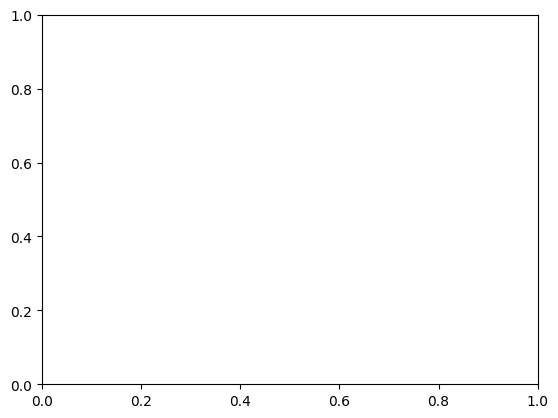

In [35]:
import matplotlib.pyplot as plt
import numpy as np

def save_range_doppler_map(rd_map, file_name):
    fig, ax = plt.subplots()
    ax.imshow(10 * np.log10(np.abs(rd_map)), cmap='jet', aspect='auto')
    ax.set_xlabel('Doppler bins')
    ax.set_ylabel('Range bins')
    plt.colorbar(ax.imshow(10 * np.log10(np.abs(rd_map)), cmap='jet', aspect='auto'), ax=ax, label='dB')
    plt.savefig(file_name, bbox_inches='tight')
    plt.close()

# Loop over the range_doppler_maps and save each one
for idx, rd_map in enumerate(range_doppler_maps):
    save_range_doppler_map(rd_map, f'range_doppler_map_{idx}.png')


In [ ]:
import numpy as np
import os

# Specify the directory where you want to save the range_doppler_maps
save_dir = './RDM_saved_data/'

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save each range_doppler_map to the directory
for idx, range_doppler_maps in enumerate(mocap_data):
    save_path = os.path.join(save_dir, 'rd_map_{}.npy'.format(idx))
    np.save(save_path, range_doppler_maps)

print("Range-Doppler maps saved to:", save_dir)


Range-Doppler maps saved to: ./RDM_saved_data/


Load Range Doppler map

In [ ]:
import numpy as np
import os

save_dir = './RDM_saved_data/'
loaded_range_doppler_maps = []
for idx in range(num_instances-1):
    load_path = os.path.join(save_dir, 'rd_map_{}.npy'.format(idx))
    loaded_map = np.load(load_path)
    loaded_range_doppler_maps.append(loaded_map)

# Now, loaded_range_doppler_maps will have the saved data
range_doppler_maps = loaded_range_doppler_maps

Save as GIF

8

In [55]:
# Use this one. 

import numpy as np
import matplotlib.pyplot as plt
import imageio
import os

# Provided parameters
max_range = (3e8 * radar.receiver.fs *
             radar.transmitter.pulse_length /
             radar.transmitter.bandwidth / 2)

# New velocity limits
velocity_min, velocity_max = -20, 20

range_axis = np.linspace(
    0, max_range, radar.samples_per_pulse, endpoint=False)

# Adjust doppler_axis to match new velocity limits
doppler_axis = np.linspace(
    velocity_max, velocity_min,radar.transmitter.pulses, endpoint=False)

# # Ensure the Doppler indices are correctly computed
# doppler_idx = np.where((doppler_axis >= velocity_min) & (doppler_axis <= velocity_max))[0]

# print("Doppler Axis:", doppler_axis)
# print("Doppler Indices:", doppler_idx)

import numpy as np
import matplotlib.pyplot as plt
import imageio
import os

# Assuming radar, range_doppler_maps, max_range, velocity_max, and velocity_min are defined elsewhere

# Prepare a tensor to store FFT data
rd_tensor = np.zeros((len(range_doppler_maps), radar.transmitter.pulses, radar.samples_per_pulse, len(range_doppler_maps[0])))

#
# Ensure img_files is initialized
img_files = []

# Iterate over the 8 channels first
for re_tensor_idx in range(range_doppler_maps[0].shape[0]):
    
    # Then loop over the 300 images that comprise each GIF for each channel
    for idx, rd_maps in enumerate(range_doppler_maps):
        
        # Store in the tensor
        rd_tensor[idx, :, :, re_tensor_idx] = 20 * np.log10(np.abs(rd_maps[re_tensor_idx, :, :]))

        # Visualization with corrected data orientation to match labels
        plt.imshow(rd_tensor[idx, :, :, re_tensor_idx], cmap='binary', aspect='auto',
                   extent=[0, max_range, velocity_max, velocity_min], vmin=-70, vmax=30)
        plt.colorbar(label='Amplitude (dB)')
        plt.xlabel('Range (m)')
        plt.ylabel('Velocity (m/s)')
        plt.title('Range Doppler Map')
        
        # Ensure Y-axis (Velocity) is centered at zero
        plt.ylim([velocity_min, velocity_max])
        
        # Save each frame as a temporary image
        img_filename = f'./RDM_images/tmp_img_channel_{re_tensor_idx+1}_{idx}.png'
        plt.savefig(img_filename)
        
        # Add to list
        img_files.append(img_filename)

        # Close the current plot to save memory
        plt.close()

    # Once all 300 images for a specific channel are saved, save them as a GIF
    gif_filename = f'./RDM_images/04_CRW2L_MC_V1_tx1_channel_{re_tensor_idx + 1}.gif'
    imageio.mimsave(gif_filename, [imageio.imread(img) for img in img_files], fps=100)

    # Cleanup the temporary images
    for img_file in img_files:
        os.remove(img_file)

    # Clear the list for the next channel
    img_files.clear()

    # Save the range-Doppler tensor for CNN processing
    np.save(f'./RDM_images/RDM_data_04_CRW2L_MC_V1_tx1_channel_{re_tensor_idx}.npy', rd_tensor)

/tmp/ipykernel_19434/3721450301.py:75: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



IndexError: index 8 is out of bounds for axis 0 with size 8

_Plot the baseband samples_


In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=timestamp[0, 0, :],
    y=np.real(baseband[0, 0, :]),
    name='I',
))
fig.add_trace(go.Scatter(
    x=timestamp[0, 0, :],
    y=np.imag(baseband[0, 0, :]),
    name='Q',
))

fig.update_layout(
    title='I/Q Baseband Signals',
    yaxis=dict(title='Amplitude (V)'),
    xaxis=dict(title='Time (s)'),
)

fig.show()

## Radar Signal Processing

### Range Profile

With an FMCW radar, the range profile of the targets could be obtained through a simple FFT across the samples of the chirp. This process is also known as the range-FFT.


In [ ]:
from scipy import signal
import radarsimpy.processing as proc

range_window = signal.windows.chebwin(radar.samples_per_pulse, at=60)
range_profile = proc.range_fft(baseband, range_window)

_Plot range profile_


In [ ]:
max_range = (3e8 * radar.receiver.fs *
             radar.transmitter.pulse_length /
             radar.transmitter.bandwidth / 2)

range_axis = np.linspace(
    0, max_range, radar.samples_per_pulse, endpoint=False)

doppler_axis = np.linspace(
    0, radar.transmitter.pulses, radar.transmitter.pulses, endpoint=False)

fig = go.Figure()

fig.add_trace(go.Surface(x=range_axis, y=doppler_axis, z=20 *
              np.log10(np.abs(range_profile[0, :, :])), colorscale='Rainbow'))

fig.update_layout(
    title='Range Profile',
    height=600,
    scene=dict(
        xaxis=dict(title='Range (m)'),
        yaxis=dict(title='Chirp'),
        zaxis=dict(title='Amplitude (dB)'),
        aspectmode='cube',
    ),
)

fig.show()

### Range-Doppler processing

Perform the FFT across the range profiles could obtan the Doppler information from the data, which is also known as the Doppler FFT.


In [ ]:
doppler_window = signal.windows.chebwin(radar.transmitter.pulses, at=60)
range_doppler = proc.doppler_fft(range_profile, doppler_window)

_Plot range-Doppler map_


In [ ]:
max_range = (3e8 * radar.receiver.fs *
             radar.transmitter.pulse_length /
             radar.transmitter.bandwidth / 2)
unambiguous_speed = 3e8 / radar.transmitter.prp[0] / \
    radar.transmitter.fc_vect[0] / 2

range_axis = np.linspace(
    0, max_range, radar.samples_per_pulse, endpoint=False)

doppler_axis = np.linspace(
    -unambiguous_speed, 0, radar.transmitter.pulses, endpoint=False)

fig = go.Figure()
fig.add_trace(go.Surface(x=range_axis, y=doppler_axis, z=20 *
              np.log10(np.abs(range_doppler[0, :, :])), colorscale='Rainbow'))

fig.update_layout(
    title='Range Doppler',
    height=600,
    scene=dict(
        xaxis=dict(title='Range (m)'),
        yaxis=dict(title='Velocity (m/s)'),
        zaxis=dict(title='Amplitude (dB)'),
        aspectmode='cube',
    ),
)

fig.show()